In [36]:
import pandas as pd
# pip install haversine
import haversine.haversine as haversine
import numpy as np

In [3]:
regions = pd.read_csv("./data/regions.csv")

In [88]:
# geographical distance matrix

centroids = dict(zip(regions.iloc[:,0], regions.iloc[:,4].apply(lambda x: [float(i) for i in x.split(',')]))) # set up

geog_dist_euclid = pd.DataFrame([[haversine(centroids[reg_row], centroids[reg_col])
                                  for reg_col in regions['NUTS3'].unique()] 
                                 for reg_row in regions['NUTS3'].unique()], 
                                columns = regions['NUTS3'].unique()).rename(
                                dict(enumerate(regions['NUTS3'].unique()))) # actual haversine distance

geog_dist_euclid = geog_dist_euclid / geog_dist_euclid.max().max() # scaled

In [89]:
# population dissimilarity matrix
population = dict(zip(regions.iloc[:,0], regions.iloc[:,2])) # set up

pop_diss = pd.DataFrame([[abs(population[reg_row] - population[reg_col])
                                  for reg_col in regions['NUTS3'].unique()] 
                                 for reg_row in regions['NUTS3'].unique()], 
                                columns = regions['NUTS3'].unique()).rename(
                                dict(enumerate(regions['NUTS3'].unique()))) # actual pop difference

pop_diss = pop_diss / pop_diss.max().max() # scaled

In [90]:
# population density dissimilarity matrix

population_density = dict(zip(regions.iloc[:,0], regions.iloc[:,2]/regions.iloc[:,3])) # set up

pop_dens_diss = pd.DataFrame([[abs(population_density[reg_row] - population_density[reg_col])
                                  for reg_col in regions['NUTS3'].unique()] 
                                 for reg_row in regions['NUTS3'].unique()], 
                                columns = regions['NUTS3'].unique()).rename(
                                dict(enumerate(regions['NUTS3'].unique()))) # actual pop density difference

pop_dens_diss = pop_dens_diss / pop_dens_diss.max().max() # scaled

In [98]:
# adjacency (dis)similarity matrix

import sys
sys.path.append("src")

import location
adj_matrix, adj_matrix_nuts = location.adjacency_similarity_matrix() # load adjacency (dis)similarity matrix

adj_matrix = pd.DataFrame(adj_matrix, columns = adj_matrix_nuts).rename(dict(enumerate(adj_matrix_nuts))) # format into pandas data frame
adj_matrix = adj_matrix.reindex(index=regions['NUTS3'].unique(), columns=regions['NUTS3'].unique()) # shuffle labels to match other matrices

In [106]:
# composite distance matrix (uses euclidean distance based on 4 above distances)

composite_distance = np.sqrt(geog_dist_euclid**2 + pop_diss**2 + pop_dens_diss**2 + adj_matrix**2)

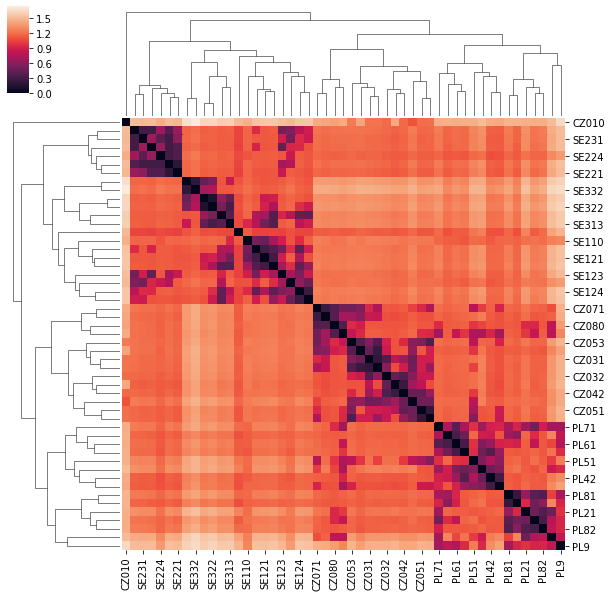

In [109]:
# cluster

import seaborn as sns

sns.clustermap(composite_distance)

In [67]:
regions.head()

,NUTS3,name,population,area,centroid
0,CZ010,Prague,1267449,496.1,"50.0663,14.463"
1,CZ020,Central Bohemian,1326876,11016.1,"49.7423,14.4549"
2,CZ031,South Bohemian,637834,10058.0,"49.1031,14.4121"
3,CZ032,Plzeň,576616,7561.0,"49.5984,13.2182"
4,CZ041,Karlovy Vary,297828,3314.3,"50.1699,12.7187"


In [110]:
composite_distance

,CZ010,CZ020,CZ031,CZ032,CZ041,CZ042,CZ051,CZ052,CZ053,CZ063,...,SE224,SE231,SE232,SE311,SE312,SE313,SE321,SE322,SE331,SE332
CZ010,0.000000,1.108068,1.224050,1.195642,1.440069,1.192177,1.204388,1.209407,1.248767,1.223184,...,1.461102,1.506809,1.511781,1.560864,1.595288,1.605069,1.636823,1.648264,1.678377,1.736931
CZ020,1.108068,0.000000,0.480641,0.580759,0.709070,0.473208,0.493797,0.487394,0.610911,0.488612,...,1.186419,1.235142,1.242969,1.280404,1.338921,1.352476,1.373182,1.393307,1.412906,1.473111
CZ031,1.224050,0.480641,0.000000,0.364211,0.809263,0.672051,0.893041,0.891693,0.564162,0.228417,...,1.168960,1.192932,1.230997,1.247952,1.300336,1.315101,1.347243,1.361112,1.395488,1.464102
CZ032,1.195642,0.580759,0.364211,0.000000,0.457535,0.368957,0.856251,0.857352,0.912351,0.612290,...,1.151048,1.169979,1.210107,1.224259,1.274702,1.290916,1.324851,1.334940,1.373559,1.443645
CZ041,1.440069,0.709070,0.809263,0.457535,0.000000,0.266220,0.807392,1.089265,1.108857,1.089118,...,1.138712,1.145477,1.196571,1.198035,1.245488,1.262095,1.297239,1.304103,1.346412,1.417135
CZ042,1.192177,0.473208,0.672051,0.368957,0.266220,0.000000,0.451302,0.671182,0.947222,0.893999,...,1.141541,1.168687,1.196000,1.215602,1.265832,1.280102,1.308088,1.321457,1.352073,1.416946
CZ051,1.204388,0.493797,0.893041,0.856251,0.807392,0.451302,0.000000,0.225882,0.561571,0.890744,...,1.148348,1.163209,1.205872,1.207803,1.256759,1.269246,1.295555,1.310054,1.339134,1.402197
CZ052,1.209407,0.487394,0.891693,0.857352,1.089265,0.671182,0.225882,0.000000,0.366934,0.667655,...,1.151742,1.171395,1.209981,1.217831,1.266503,1.278019,1.305087,1.321679,1.349422,1.412670
CZ053,1.248767,0.610911,0.564162,0.912351,1.108857,0.947222,0.561571,0.366934,0.000000,0.367435,...,1.181271,1.203715,1.243920,1.249600,1.302714,1.313536,1.336702,1.356638,1.379374,1.440172
CZ063,1.223184,0.488612,0.228417,0.612290,1.089118,0.893999,0.890744,0.667655,0.367435,0.000000,...,1.168213,1.188307,1.230678,1.240713,1.291349,1.304000,1.334307,1.350368,1.381558,1.447931
